In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing.text import Tokenizer
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding,ConvLSTM2D
from keras import layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [0]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm_notebook as tqdm

     / 368kB 1.5MB/s
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=bf04fa5f60ec1136fb7280bab1c15b70991c47cedc3338a0037c5501a8050934
  Stored in directory: /tmp/pip-ephem-wheel-cache-iq5kvy4m/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.38.0
    Uninstalling tqdm-4.38.0:
      Successfully uninstalled tqdm-4.38.0


#### Connecting to Google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
os.chdir("/content/drive/My Drive/CA684_Assignment/Dev-set")

#### Input dev set Ground Truth file

In [0]:
ground_truth= pd.read_csv("Ground-truth/ground-truth.csv")

In [0]:
ground_truth.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [0]:
ground_truth = ground_truth.drop(['nb_short-term_annotations', 'nb_long-term_annotations'],axis=1)
ground_truth.head()

,video,short-term_memorability,long-term_memorability
0,video3.webm,0.924,0.846
1,video4.webm,0.923,0.667
2,video6.webm,0.863,0.700
3,video8.webm,0.922,0.818
4,video10.webm,0.950,0.900


### Captions

In [0]:
captions = pd.read_csv("Captions/dev-set_video-captions.txt",delimiter='\t',names=('video','caption'))
captions.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


#### Histogram to check the skewness of data - Short term are more memorable than long term

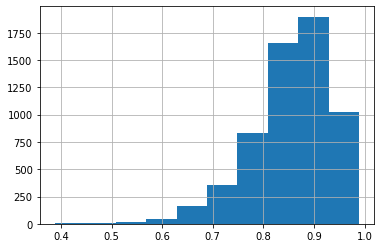

In [0]:
ground_truth['short-term_memorability'].hist()

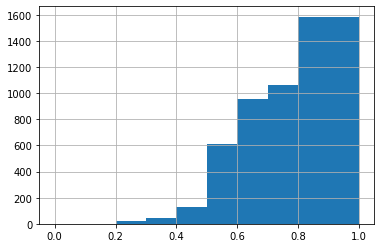

In [0]:
ground_truth['long-term_memorability'].hist()

In [0]:
df = pd.merge(ground_truth, captions, on = 'video')

Cleaning the captions - removing special characters, numbers and converting all caption to lower case 

In [0]:
captions_clean = []
for i in range(0, 6000):
    captions_tmp = re.sub('[\W^0-9]', ' ', captions['caption'][i])
    captions_tmp = captions_tmp.lower().split()
    captions_tmp = [word for word in captions_tmp if not word in set(stopwords.words('english'))]
    captions_clean.append(' '.join(captions_tmp))

#### Weights are given to certain words based on their positive and negative coefficients (R. Gupta et al. paper 2018) Higher weight to positive coefficient words (weights range between 0.51 to 0.66) Lower weigh to negative coefficient words (weights range from 0.1 to 0.23)

In [0]:
neg_words = {'mountains':0.10,'sunset':0.11,'trees':0.12,'mountain':0.13,'clouds':0.14,
                     'river':0.15,'aerialof':0.16,'lake':0.17,'forest':0.18,'kenya':0.19,'landscape':0.20,
                     'valley':0.21,'leaves':0.22,'sun':0.23}
pos_words = {'woman':0.51,'eating':0.52,'putting':0.53,'lying':0.54,'girl':0.55,'selfie':0.56,'relaxing':0.57,
                    'jellyfish':0.58,'cat':0.59,'super':0.60,'slow':0.61,
                    'super':0.62,'american':0.63,'potrait':0.64,'pregnant':0.65,'couple':0.66}
positive = []
list1=[]
negetive = []
for i in range(0, 6000):
    pw=0
    nw=0
    text = re.sub('[^a-zA-Z]', ' ', captions['caption'][i])
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in set(stopwords.words('english'))]
#     print(text)
    for word in text:
        if(word in set(pos_words.keys())):
                pw = pw + pos_words[word]
        if(word in set(neg_words.keys())):
                nw = pw + neg_words[word]
    positive.append(pw)
    negetive.append(nw)

words_df = pd.DataFrame(
    {'pos_weights': positive,
     'neg_weights': negetive
    })
words_df.shape

(6000, 2)

#### Vectorizing the caption data 

In [0]:
df = captions_clean
counts = Counter()
for i, cap in enumerate(df):
    counts.update(cap.split())
vect = TfidfVectorizer(ngram_range = (1,4)).fit(df)
vect_transformed_X_train = vect.transform(df)
len_token = len(vect.get_feature_names())
len_token = len(counts)
len_token1=len_token+2
tokenizer = Tokenizer(num_words=len_token)
tokenizer.fit_on_texts(list(vect.get_feature_names()))
features=tokenizer.texts_to_matrix(list(df),mode='binary')

In [0]:
len_token

5098

In [0]:
caparr = np.concatenate((features, words_df), axis=1)

In [0]:
caparr.shape

(6000, 5100)

In [0]:
# len(caparr
# len_token

In [0]:
caption_data = caparr
gt = ground_truth[['short-term_memorability','long-term_memorability']].values

#### Split data into test and training 

In [0]:
cap_train, cap_test, gt_train, gt_test = train_test_split(caption_data, gt, test_size = 0.20,random_state=42)

In [0]:
cap_train.shape

(4800, 5100)

#### Function to calculate Spearman's coefficient

In [0]:
def Get_score(Y_pred,Y_true):   
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

## Building Model

### RNN

In [0]:
# model = Sequential()
# model.add(layers.Dense(200,activation='sigmoid',kernel_regularizer=None,input_shape=(len_token1,)))
# model.add(layers.Dropout(0.1))
# model.add(layers.Dense(2,activation='relu'))
      
# # compile the model 
# model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['accuracy'])

# # training the model 
# history = model.fit(cap_train,gt_train,epochs=20,validation_data=(cap_test,gt_test))

In [0]:
model = Sequential()
model.add(layers.Dense(200,activation='softmax',kernel_regularizer=None,input_shape=(len_token1,)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2,activation='relu'))
      
# compile the model 
model.compile(optimizer='Adamax',loss='mean_absolute_error',metrics=['cosine_proximity','accuracy','mae'])

# training the model 
history = model.fit(cap_train,gt_train,epochs=20,validation_data=(cap_test,gt_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 461us/step - loss: 0.5386 - cosine_proximity: 0.9852 - accuracy: 0.6748 - mae: 0.5386 - val_loss: 0.2520 - val_cosine_proximity: 0.9942 - val_accuracy: 0.7100 - val_mae: 0.2520
Epoch 2/20
4800/4800 [==============================] - 2s 439us/step - loss: 0.1233 - cosine_proximity: 0.9952 - accuracy: 0.7035 - mae: 0.1233 - val_loss: 0.0881 - val_cosine_proximity: 0.9952 - val_accuracy: 0.7100 - val_mae: 0.0881
Epoch 3/20
4800/4800 [==============================] - 2s 428us/step - loss: 0.0881 - cosine_proximity: 0.9954 - accuracy: 0.7035 - mae: 0.0881 - val_loss: 0.0877 - val_cosine_proximity: 0.9951 - val_accuracy: 0.7100 - val_mae: 0.0877
Epoch 4/20
4800/4800 [==============================] - 2s 430us/step - loss: 0.0873 - cosine_proximity: 0.9954 - accuracy: 0.7035 - mae: 0.0873 - val_loss: 0.0875 - val_cosine_proximity: 0.9952 - val_accuracy: 0.7100 - val_mae: 0.0875
Epoch 5/

In [0]:
predictions_caption_RNN = model.predict(cap_test)
predictions_caption_RNN

array([[0.8924968 , 0.78578794],
       [0.8553598 , 0.80166745],
       [0.876129  , 0.8110055 ],
       ...,
       [0.8764062 , 0.8096849 ],
       [0.8685574 , 0.792549  ],
       [0.86773473, 0.7702991 ]], dtype=float32)

In [0]:
Get_score(predictions_caption_RNN, gt_test)

The Spearman's correlation coefficient is: 0.440
The Spearman's correlation coefficient is: 0.174


### DecisionTree

In [0]:
from sklearn.tree import DecisionTreeRegressor
DTregressor = DecisionTreeRegressor()
DTregressor.fit(cap_train, gt_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
predictions_caption_DT = DTregressor.predict(cap_test)
Get_score(predictions_caption_DT, gt_test)

The Spearman's correlation coefficient is: 0.275
The Spearman's correlation coefficient is: 0.132


### SVR

In [0]:
gt_short = ground_truth[['short-term_memorability']].values
cap_train, cap_test, gt_train_short, gt_test_short = train_test_split(caption_data,gt_short, test_size=0.2, random_state=42)

In [0]:
from sklearn.svm import SVR
model = SVR(C=100).fit(cap_train,gt_train_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
predictions_caption_svm_short = model.predict(cap_test)
Get_score(predictions_caption_svm_short,gt_test_short)

The Spearman's correlation coefficient is: 0.428


In [0]:
gt_long = ground_truth[['long-term_memorability']].values
cap_train, cap_test, gt_train_long, gt_test_long = train_test_split(caption_data,gt_long, test_size=0.2, random_state=42)
from sklearn.svm import SVR
model = SVR(C=100).fit(cap_train,gt_train_long)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
predictions_caption_svm_long = model.predict(cap_test)
Get_score(predictions_caption_svm_long,gt_test_long)

The Spearman's correlation coefficient is: 0.179


In [0]:
# prediction_svm=np.append(predictions_caption_svm_short,predictions_caption_svm_long)
# np.vstack(predictions_caption_svm_short)
# np.vstack(predictions_caption_svm_long)
prediction_caption_SVR=np.column_stack((predictions_caption_svm_short,predictions_caption_svm_long))

In [0]:
prediction_caption_SVR.shape

(1200, 2)

In [0]:
Get_score(prediction_caption_SVR,gt_test)

The Spearman's correlation coefficient is: 0.428
The Spearman's correlation coefficient is: 0.179


### Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
RFregressor = RandomForestRegressor(n_estimators = 150)
RFregressor.fit(cap_train, gt_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
predictions_caption_RF=RFregressor.predict(cap_test)
Get_score(predictions_caption_RF,gt_test)

The Spearman's correlation coefficient is: 0.422
The Spearman's correlation coefficient is: 0.166


### C3D features

Function to read C3D features and files from directory

In [0]:
def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()]
    return C3D

def vname2ID(vnames):
    """Parse video digital id from its name
    vnames: a list contains file names"""
    vid = [ os.path.splitext(vn)[0]+'.webm' for vn in vnames]
    return vid

In [0]:
os.chdir("/content/drive/My Drive/CA684_Assignment/Dev-set/")

In [0]:
!pwd

/content/drive/.shortcut-targets-by-id/1UWIdExqb5P94RLqkaiODcwFC2v7g3lB2/CA684_Assignment/Dev-set


In [0]:
C3D_Feat_path = '/content/drive/My Drive/CA684_Assignment/Dev-set/'
# Load video related features first
# it helps with the organization of the video names


vid = ground_truth.video.values

C3D_Features = pd.DataFrame({'video': vid,
                   'C3D': [read_C3D(C3D_Feat_path+'C3D'+'/'+os.path.splitext(item)[0]+'.txt') for item in vid],
                       })


In [0]:
C3D_Features.head

<bound method NDFrame.head of                video                                                C3D
0        video3.webm  [0.02024942, 0.0015778, 0.00082625, 0.00094509...
1        video4.webm  [0.000118, 0.00089075, 0.00018769, 4.543e-05, ...
2        video6.webm  [0.01176522, 0.00074577, 0.00078353, 1.328e-05...
3        video8.webm  [0.00022343, 0.00016499, 7.35e-06, 1.615e-05, ...
4       video10.webm  [9.006e-05, 0.00061494, 0.00343634, 0.00128092...
...              ...                                                ...
5995  video7488.webm  [0.35724622, 0.07598178, 0.00302532, 2.772e-05...
5996  video7489.webm  [0.19280288, 0.00093812, 0.00506054, 1.35e-06,...
5997  video7491.webm  [2.589e-05, 0.00012192, 2.781e-05, 2.608e-05, ...
5998  video7492.webm  [0.26509121, 0.09653918, 5.971e-05, 0.00022735...
5999  video7493.webm  [0.02058949, 0.00122141, 0.00206607, 0.0023161...

[6000 rows x 2 columns]>

In [0]:
C3Darr = np.stack(C3D_Features['C3D'].values)
gt = ground_truth[['short-term_memorability','long-term_memorability']].values

C3D_train, C3D_test, gt_train, gt_test = train_test_split(C3Darr,gt, test_size=0.2, random_state=42)

### RNN

In [0]:
model = Sequential()
model.add(layers.Dense(200,activation='softmax',kernel_regularizer=None,input_shape=(C3Darr.shape[1],)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2,activation='relu'))
      
# compile the model 
model.compile(optimizer='Adamax',loss='mean_absolute_error',metrics=['cosine_proximity','accuracy','mae'])

# training the model 
history = model.fit(C3D_train,gt_train,epochs=20,validation_data=(C3D_test,gt_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 0s 88us/step - loss: 0.5822 - cosine_proximity: 0.9163 - accuracy: 0.7035 - mae: 0.5822 - val_loss: 0.2951 - val_cosine_proximity: 0.9931 - val_accuracy: 0.7100 - val_mae: 0.2951
Epoch 2/20
4800/4800 [==============================] - 0s 57us/step - loss: 0.1375 - cosine_proximity: 0.9947 - accuracy: 0.7035 - mae: 0.1375 - val_loss: 0.0892 - val_cosine_proximity: 0.9952 - val_accuracy: 0.7100 - val_mae: 0.0892
Epoch 3/20
4800/4800 [==============================] - 0s 57us/step - loss: 0.0886 - cosine_proximity: 0.9954 - accuracy: 0.7035 - mae: 0.0886 - val_loss: 0.0890 - val_cosine_proximity: 0.9951 - val_accuracy: 0.7100 - val_mae: 0.0890
Epoch 4/20
4800/4800 [==============================] - 0s 62us/step - loss: 0.0881 - cosine_proximity: 0.9954 - accuracy: 0.7035 - mae: 0.0881 - val_loss: 0.0890 - val_cosine_proximity: 0.9952 - val_accuracy: 0.7100 - val_mae: 0.0890
Epoch 5/20
4

In [0]:
predictions_RNN = model.predict(C3D_test)
predictions_RNN

array([[0.8826228 , 0.7971159 ],
       [0.85601586, 0.7786517 ],
       [0.8918224 , 0.8034682 ],
       ...,
       [0.8930155 , 0.80535364],
       [0.90880275, 0.815766  ],
       [0.8890915 , 0.80073535]], dtype=float32)

In [0]:
Get_score(predictions_RNN, gt_test)

The Spearman's correlation coefficient is: 0.278
The Spearman's correlation coefficient is: 0.132


### Decision Tree

In [0]:
DTregressor = DecisionTreeRegressor()
DTregressor.fit(cap_train, gt_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
predictions = DTregressor.predict(cap_test)
Get_score(predictions, gt_test)

The Spearman's correlation coefficient is: 0.268
The Spearman's correlation coefficient is: 0.133


### SVR

In [0]:
gt_short = ground_truth[['short-term_memorability']].values
C3D_train, C3D_test, gt_train_short, gt_test_short = train_test_split(C3Darr,gt_short, test_size=0.2, random_state=42)

In [0]:
from sklearn.svm import SVR
model = SVR(C=100).fit(C3D_train,gt_train_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
predictions = model.predict(C3D_test)
Get_score(predictions,gt_test_short)

The Spearman's correlation coefficient is: 0.161


In [0]:
gt_long = ground_truth[['long-term_memorability']].values
C3D_train, C3D_test, gt_train_long, gt_test_long = train_test_split(C3Darr,gt_long, test_size=0.2, random_state=42)

In [0]:
predictions = model.predict(C3D_test)
Get_score(predictions,gt_test_long)

The Spearman's correlation coefficient is: 0.092


### Random Forest 

In [0]:
from sklearn.ensemble import RandomForestRegressor
RFregressor = RandomForestRegressor(n_estimators = 150)
RFregressor.fit(C3D_train, gt_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
predictions_RF=RFregressor.predict(C3D_test)
Get_score(predictions_RF,gt_test)

The Spearman's correlation coefficient is: 0.316
The Spearman's correlation coefficient is: 0.100


### Aesthetic Features

In [0]:
def aes_fea_read(df, filename):
  df1 = pd.read_csv(filename, header=None)
  df1['video'] = filename[filename.find('video'):filename.find('.txt')] + '.webm'
  df = df.append(df1, ignore_index=True)
  return df

def reading_file_names(path):
  files = []
  file_number=0
  # r=root, d=directories, f = files
  for r, d, f in os.walk(path):
      for file in f:
          if '.txt' in file:
              files.append(os.path.join(r, file))
              file_number = file_number + 1
  print("total files read = " + str(file_number))
  return files

In [0]:
asthetic_Feat_path = '/content/drive/My Drive/aesthetic-features/dev-set_aesthetic-features/features/aesthetic_visual_features/aesthetic_feat_dev-set_median/'
files = reading_file_names(asthetic_Feat_path)
dataframe_aes = pd.DataFrame()
for filename in files:
    dataframe_aes = aes_fea_read(dataframe_aes, filename)
   
dataframe_aes.head()

total files read = 6000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,video
0,0.353007,0.308923,0.284553,0.225039,0.253096,0.514355,55.062002,0.083333,0.004221,1.0,15.0,0.00,0.5,0.844876,13.0,0.966736,3.158975,7.799011,9.382395,7.113285,22.907121,11.712100,15.726967,43.853436,5.0,0.253197,0.166731,73.0,190.0,0.636582,0.0,0.0,0.030422,0.029239,0.010675,7.360682,7.276642,7.192997,-0.008309,0.012207,...,0.259818,0.414993,0.328159,0.384097,0.414476,0.245120,0.465370,0.141276,0.101100,0.104613,0.481928,0.103862,0.410256,0.450861,0.264921,1.259652,0.258827,1.800927,1.800927,0.353435,0.601387,0.544208,0.816366,0.657737,0.419518,0.058438,0.088509,0.121265,0.002881,-0.002206,-0.003555,0.386096,0.180473,0.365270,1.043706,0.0,-0.409691,-0.468646,0.735105,video6632.webm
1,0.168417,0.089344,0.541439,0.153814,0.518419,0.240795,50.625188,0.125000,0.000553,2.0,17.0,0.05,0.5,0.901786,17.0,0.172053,0.397873,0.736124,2.634164,2.302000,0.810022,1.935664,2.644606,3.099307,9.0,0.522239,0.462534,79.0,202.0,0.650309,0.0,0.0,0.045983,0.022741,0.008003,7.224600,7.294450,7.324708,0.011352,-0.011723,...,0.133063,0.302486,0.266077,0.143957,0.097494,0.080860,0.054758,0.078787,0.076744,0.320708,0.800914,0.659215,0.654679,0.649544,0.924679,2.324563,1.923246,1.860414,1.860414,0.696142,0.258678,0.932650,0.419849,0.602226,0.914479,0.124725,0.090859,0.001478,0.003772,-0.004476,-0.000000,0.000000,0.169706,0.044193,1.401191,0.0,0.299827,0.181719,0.402697,video6634.webm
2,0.581810,0.194872,0.531678,0.125891,0.480966,0.358678,52.473407,0.604938,0.000302,2.0,18.0,0.05,0.5,0.772727,18.0,0.276161,0.949043,0.786576,0.864610,1.459549,2.037820,2.010496,3.439723,5.247894,9.0,0.476793,0.391343,99.0,154.0,0.352407,0.0,0.0,0.020502,0.014638,0.005407,5.300602,4.868283,4.798607,-0.010021,-0.034828,...,0.381004,0.340933,0.602290,0.574308,0.190684,0.242257,0.262524,0.089257,0.117701,0.594114,0.045198,0.073597,0.484025,0.442133,1.597913,0.119987,0.192165,3.103221,3.103221,0.473655,0.694643,0.952657,0.505598,0.481609,0.039222,0.176849,0.040903,0.001147,0.002180,-0.001669,-0.000008,0.877948,0.280758,0.229451,1.477636,0.0,0.391471,0.060211,0.338636,video6633.webm
3,0.604572,0.657199,0.465797,0.526192,0.323581,0.476609,56.950678,0.600000,0.025879,2.0,17.0,0.05,0.5,0.606219,18.0,0.000084,0.000349,0.000888,0.133072,0.000521,0.000877,0.153781,0.154507,0.154557,9.0,0.314131,0.280397,66.0,173.0,0.676752,0.0,0.0,0.032379,0.014033,0.005080,6.138215,6.817259,7.249521,-0.032182,-0.030379,...,0.596026,0.602340,0.589654,0.592583,0.739536,0.272226,0.559406,0.297302,0.327257,0.403357,0.644141,0.670140,0.676132,0.672393,0.727653,1.673944,1.639132,0.460414,0.460414,0.505202,0.569160,0.704965,0.505761,0.204184,0.675914,0.169505,0.019740,0.025946,0.000249,0.000074,-0.000005,0.103966,0.046547,0.519998,1.098700,0.0,0.265116,0.340027,0.035195,video6635.webm
4,0.141382,0.218025,0.341507,0.124468,0.306108,0.481848,51.203502,0.166667,0.000389,3.0,16.0,0.10,0.5,0.528233,17.0,0.211523,0.150342,0.366948,1.259084,1.238053,0.520253,1.227052,1.323680,1.774546,9.0,0.311975,0.299320,55.0,104.0,0.519861,0.0,0.0,0.034262,0.017544,0.006136,6.350336,6.256131,6.203816,0.010258,-0.002904,...,0.164098,0.113424,0.124538,0.154363,0.204238,0.261588,0.137761,0.281860,0.325721,0.387833,0.223612,0.389716,0.271048,0.233768,1.064785,0.604303,1.090317,0.537341,0.537341,0.586517,0.342995,0.446831,0.599706,0.279681,0.105633,0.164282,0.060408,0.010828,-0.023740,0.001264,0.000184,0.046312,0.050476,0.189169,0.487030,0.0,0.273047,0.151776,0.441400,video6637.webm


In [0]:
aes_grtruth_merge = pd.merge(ground_truth, dataframe_aes, on='video')

In [0]:
aes_grtruth_merge.head()

,video,short-term_memorability,long-term_memorability,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108
0,video3.webm,0.924,0.846,0.180874,0.715626,0.198930,0.610453,0.121610,0.692880,55.008914,0.103175,0.001049,2.0,17.0,0.05,0.5,0.519604,17.0,0.005960,0.008102,0.020343,0.770542,2.004125,0.021858,1.988820,2.013504,2.019222,9.0,0.120265,0.080634,40.0,119.0,0.735895,0.0,0.0,0.018776,0.019295,0.007748,6.274252,5.379075,...,0.213352,0.095509,0.087230,0.033329,0.056038,0.662861,0.771214,0.829652,0.924071,0.927459,0.077285,0.360043,0.328821,0.143918,0.189463,0.120016,0.679751,0.598540,2.230930,2.230930,0.369616,0.704061,0.598133,0.495474,0.609570,0.048284,0.136023,0.080460,0.069851,0.009017,-0.002154,-0.000850,0.000000,0.260845,0.294153,0.575061,0.0,0.129661,0.412381,0.788761
1,video4.webm,0.923,0.667,0.146076,0.550070,0.460729,0.424397,0.341807,0.398212,47.307755,0.119048,0.001859,2.0,16.0,0.05,0.5,0.826721,17.0,0.574806,0.143842,2.256436,2.756384,1.086561,5.479923,2.133483,1.732435,9.536329,9.0,0.353469,0.293591,93.0,237.0,0.604444,0.0,0.0,0.026247,0.023164,0.008719,7.564623,7.510288,...,0.117375,0.251914,0.313148,0.154196,0.159286,0.569429,0.512815,0.251813,0.315495,0.621390,0.506164,0.243233,0.236492,0.225829,0.175110,1.155411,0.626569,0.629879,3.518818,3.518818,0.516974,0.499703,0.529186,0.508357,0.452106,0.088257,0.156600,0.005414,0.011766,0.001006,0.000007,-0.000399,0.920270,0.337932,0.382134,0.943198,0.0,0.692224,0.762354,-0.561793
2,video6.webm,0.863,0.700,0.063898,0.827439,0.211925,0.720297,0.129499,0.722464,60.535453,0.069048,0.000423,1.0,18.0,0.00,0.5,0.925215,18.0,0.001088,0.007850,0.012946,0.503774,0.500744,0.011369,0.495924,0.504864,0.511403,9.0,0.122787,0.078270,30.0,114.0,0.752917,0.0,0.0,0.011631,0.010970,0.004174,6.816686,5.902598,...,0.061944,0.064526,0.068016,0.063560,0.067906,0.782612,0.915448,0.742627,0.929079,0.819570,0.325139,0.053818,0.292247,0.062686,0.096624,0.567694,0.083037,0.532664,0.172798,0.172798,0.444921,0.491387,0.482771,0.297088,0.630684,0.874500,0.098737,0.093660,0.086411,0.006172,0.002896,0.002309,0.374684,0.019155,0.187358,0.512601,0.0,0.438261,-0.219560,0.276687
3,video8.webm,0.922,0.818,0.380539,0.134683,0.746891,0.171604,0.697045,0.452995,47.827289,0.580247,0.008550,2.0,14.0,0.45,0.5,0.584303,16.0,6.821453,0.211897,20.599044,20.597047,1.675345,36.579662,8.624648,1.997418,60.334606,8.0,0.700016,0.691673,61.0,162.0,0.469074,0.0,0.0,0.034828,0.014983,0.005811,5.478771,5.776676,...,0.529747,0.097027,0.134220,0.117635,0.103768,0.103688,0.097834,0.355580,0.288330,0.208370,0.767993,0.706242,0.697557,0.698124,0.669603,2.198174,1.995827,1.771978,3.649645,3.649645,0.327396,0.825431,0.583132,0.503702,0.495120,0.495396,0.121759,0.087158,0.083780,-0.000375,0.000568,0.000514,0.970656,0.435550,0.431595,1.142377,0.0,0.424483,0.326030,0.688481
4,video10.webm,0.950,0.900,0.427258,0.381448,0.582746,0.409475,0.489531,0.198180,39.394310,0.583333,0.039983,7.0,8.0,0.50,0.5,0.235256,9.0,3.353624,1.457271,9.106350,9.757566,6.015925,23.798947,8.782157,10.694530,42.722976,7.0,0.480419,0.391819,95.0,250.0,0.639182,0.0,0.0,0.047711,0.051303,0.019465,7.648013,7.741015,...,0.350875,0.599704,0.724789,0.625646,0.501627,0.327160,0.598499,0.529061,0.531380,0.509560,0.671278,0.379598,0.262728,0.237663,0.244884,1.682174,0.814582,0.617273,5.050162,4.715430,0.581783,0.267555,0.548738,0.524388,0.302570,0.714883,0.157093,0.058108,0.008797,-0.006392,0.005307,0.000065,0.000000,0.442575,0.347355,1.285838,0.0,-0.279630,-0.012414,0.197281


In [0]:
aes_feature = aes_grtruth_merge.iloc[:,3:112].values

In [0]:
aes_feature

array([[ 0.180874,  0.715626,  0.19893 , ...,  0.129661,  0.412381,
         0.788761],
       [ 0.146076,  0.55007 ,  0.460729, ...,  0.692224,  0.762354,
        -0.561793],
       [ 0.063898,  0.827439,  0.211925, ...,  0.438261, -0.21956 ,
         0.276687],
       ...,
       [ 0.177078,  0.221348,  0.67387 , ...,  0.38719 ,  0.244293,
         0.341741],
       [ 0.113838,  0.585274,  0.496719, ...,  0.00308 ,  0.365075,
        -1.04308 ],
       [ 0.554715,  0.132732,  0.691821, ...,  0.783961,  0.621886,
        -0.569049]])

In [0]:
AESarr = aes_feature
gt = ground_truth[['short-term_memorability','long-term_memorability']].values

AES_train, AES_test, gt_train, gt_test = train_test_split(AESarr,gt, test_size=0.2, random_state=1)

### RNN

In [0]:
model = Sequential()
model.add(layers.Dense(200,activation='softmax',kernel_regularizer=None,input_shape=(AESarr.shape[1],)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2,activation='relu'))
      
# compile the model 
model.compile(optimizer='Adamax',loss='mean_absolute_error',metrics=['cosine_proximity','accuracy','mae'])

# training the model 
history = model.fit(AES_train,gt_train,epochs=20,validation_data=(AES_test,gt_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 0s 78us/step - loss: 0.4976 - cosine_proximity: 0.9668 - accuracy: 0.6981 - mae: 0.4976 - val_loss: 0.2200 - val_cosine_proximity: 0.9956 - val_accuracy: 0.7233 - val_mae: 0.2200
Epoch 2/20
4800/4800 [==============================] - 0s 55us/step - loss: 0.1424 - cosine_proximity: 0.9953 - accuracy: 0.7002 - mae: 0.1424 - val_loss: 0.0939 - val_cosine_proximity: 0.9955 - val_accuracy: 0.7233 - val_mae: 0.0939
Epoch 3/20
4800/4800 [==============================] - 0s 56us/step - loss: 0.1224 - cosine_proximity: 0.9953 - accuracy: 0.7002 - mae: 0.1224 - val_loss: 0.0935 - val_cosine_proximity: 0.9955 - val_accuracy: 0.7233 - val_mae: 0.0935
Epoch 4/20
4800/4800 [==============================] - 0s 55us/step - loss: 0.1203 - cosine_proximity: 0.9953 - accuracy: 0.7002 - mae: 0.1203 - val_loss: 0.0923 - val_cosine_proximity: 0.9955 - val_accuracy: 0.7233 - val_mae: 0.0923
Epoch 5/20
4

In [0]:
predictions_RNN = model.predict(AES_test)
predictions_RNN

array([[0.86557794, 0.80182403],
       [0.86557794, 0.80182403],
       [0.86557794, 0.80182403],
       ...,
       [0.86557794, 0.80182403],
       [0.86557794, 0.80182403],
       [0.86557794, 0.80182403]], dtype=float32)

In [0]:
Get_score(predictions_RNN, gt_test)

The Spearman's correlation coefficient is: -0.050
The Spearman's correlation coefficient is: 0.002


### Descion Tree

In [0]:
from sklearn.tree import DecisionTreeRegressor
DTregressor = DecisionTreeRegressor()
DTregressor.fit(AES_train, gt_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [0]:
predictions = DTregressor.predict(AES_test)
Get_score(predictions, gt_test)

The Spearman's correlation coefficient is: 0.141
The Spearman's correlation coefficient is: 0.032


### SVR

In [0]:
gt_short = ground_truth[['short-term_memorability']].values
AES_train, AES_test, gt_train_short, gt_test_short = train_test_split(AESarr,gt_short, test_size=0.2, random_state=1)

In [0]:
from sklearn.svm import SVR
model = SVR(C=100).fit(AES_train,gt_train_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
predictions = model.predict(AES_test)
Get_score(predictions,gt_test_short)

The Spearman's correlation coefficient is: 0.263


In [0]:
gt_long = ground_truth[['short-term_memorability']].values
AES_train, AES_test, gt_train_long, gt_test_long = train_test_split(AESarr,gt_long, test_size=0.2, random_state=42)

In [0]:
predictions = model.predict(AES_test)
Get_score(predictions,gt_test_short)

The Spearman's correlation coefficient is: -0.053


### Random forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
RFregressor = RandomForestRegressor(n_estimators = 150)
RFregressor.fit(AES_train, gt_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
predictions_RF=RFregressor.predict(AES_test)
Get_score(predictions_RF,gt_test)

The Spearman's correlation coefficient is: -0.006
The Spearman's correlation coefficient is: 0.027


###Ensembled approach (caption)

Weighted average ensemble approach to increase the accuracy [60% of RNN , 30% of SVR and 10% of Random forest model]

In [0]:
prediction_final = 0.60*predictions_caption_RNN + 0.30*prediction_caption_SVR+ 0.10*predictions_caption_RF

In [0]:
prediction_final

array([[0.87684404, 0.7798028 ],
       [0.85267728, 0.78807911],
       [0.87094763, 0.81888294],
       ...,
       [0.86857399, 0.81512232],
       [0.86982417, 0.7933572 ],
       [0.8615729 , 0.77379898]])

#### On combining the models Spearman's correlation for short term memory is **0.464** and long term memory is **0.200**

In [0]:
Get_score(prediction_final,gt_test)

The Spearman's correlation coefficient is: 0.464
The Spearman's correlation coefficient is: 0.200


## BUILDING FINAL MODEL ON TEST SET

#### Above exploration of featuers, "Video Captions" give better results,so my final prediction is based on video captions.

In [0]:
ground_truth_test= pd.read_csv("Ground-truth/ground-truth.csv")

In [0]:
ground_truth_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


In [0]:
ground_truth_test = ground_truth_test.drop(['nb_short-term_annotations', 'nb_long-term_annotations'],axis=1)
ground_truth_test.head()

,video,short-term_memorability,long-term_memorability
0,video3.webm,0.924,0.846
1,video4.webm,0.923,0.667
2,video6.webm,0.863,0.700
3,video8.webm,0.922,0.818
4,video10.webm,0.950,0.900


In [0]:
os.chdir("/content/drive/My Drive/CA684_Assignment/Test-set")

#### Reading captions file of test dataset

In [0]:
captions_test = pd.read_csv("Captions_test/test-set-1_video-captions.txt",delimiter='\t',names=('video','caption'))
captions_test.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


In [0]:
os.chdir("/content/drive/My Drive/CA684_Assignment/Dev-set")

In [0]:
captions_train = pd.read_csv("Captions/dev-set_video-captions.txt",delimiter='\t',names=('video','caption'))
captions_train.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [0]:
captions = pd.concat([captions_train, captions_test],ignore_index=True)

In [0]:
captions.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [0]:
captions.tail()

,video,caption
7995,video10004.webm,astronaut-in-outer-space-against-the-backdrop-...
7996,video10005.webm,young-women-lying-on-sunbed-and-applying-sun-c...
7997,video10006.webm,doctor-talking-to-patient-using-a-tablet-to-ex...
7998,video10007.webm,businessman-sitting-on-the-beach-on-inflatable...
7999,video10008.webm,woman-eating-ice-cream-and-sitting-in-the-stre...


In [0]:
captions_clean = []
for i in range(0, 8000):
    captions_tmp = re.sub('[\W^0-9]', ' ', captions['caption'][i])
    captions_tmp = captions_tmp.lower().split()
    captions_tmp = [word for word in captions_tmp if not word in set(stopwords.words('english'))]
    captions_clean.append(' '.join(captions_tmp))

In [0]:
neg_words = {'mountains':0.10,'sunset':0.11,'trees':0.12,'mountain':0.13,'clouds':0.14,
                     'river':0.15,'aerialof':0.16,'lake':0.17,'forest':0.18,'kenya':0.19,'landscape':0.20,
                     'valley':0.21,'leaves':0.22,'sun':0.23}
pos_words = {'woman':0.51,'eating':0.52,'putting':0.53,'lying':0.54,'girl':0.55,'selfie':0.56,'relaxing':0.57,
                    'jellyfish':0.58,'cat':0.59,'super':0.60,'slow':0.61,
                    'super':0.62,'american':0.63,'potrait':0.64,'pregnant':0.65,'couple':0.66}
positive = []
list1=[]
negetive = []
for i in range(0, 8000):
    pw=0
    nw=0
    text = re.sub('[^a-zA-Z]', ' ', captions['caption'][i])
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in set(stopwords.words('english'))]
#     print(text)
    for word in text:
        if(word in set(pos_words.keys())):
                pw = pw + pos_words[word]
        if(word in set(neg_words.keys())):
                nw = pw + neg_words[word]
    positive.append(pw)
    negetive.append(nw)

words_df = pd.DataFrame(
    {'pos_weights': positive,
     'neg_weights': negetive
    })
words_df.shape

(8000, 2)

In [0]:
df = captions_clean
counts = Counter()
for i, cap in enumerate(df):
    counts.update(cap.split())
vect = TfidfVectorizer(ngram_range = (1,4)).fit(df)
vect_transformed_X_train = vect.transform(df)
len_token = len(vect.get_feature_names())
len_token = len(counts)
len_token1=len_token+2
tokenizer = Tokenizer(num_words=len_token)
tokenizer.fit_on_texts(list(vect.get_feature_names()))
features=tokenizer.texts_to_matrix(list(df),mode='binary')

In [0]:
len_token

5773

In [0]:
caparr = np.concatenate((features, words_df), axis=1)

In [0]:
caparr.shape

(8000, 5775)

Using first 6000 captions for Training and remaining 2000 for testing 

In [0]:
caparr_train = caparr[:6000]

In [0]:
caparr_test = caparr[6000:]

In [0]:
caparr_train.shape

(6000, 5775)

In [0]:
caparr_test.shape

(2000, 5775)

In [0]:
def Get_score(Y_pred,Y_true):   
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

In [0]:
caption_data = caparr_train
gt = ground_truth[['short-term_memorability','long-term_memorability']].values

In [0]:
cap_train, cap_test, gt_train, gt_test = train_test_split(caption_data, gt, test_size = 0.20,random_state=42)

### RNN

In [0]:
model = Sequential()
model.add(layers.Dense(200,activation='softmax',kernel_regularizer=None,input_shape=(len_token1,)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(2,activation='relu'))
      
# compile the model 
model.compile(optimizer='Adamax',loss='mean_absolute_error',metrics=['cosine_proximity','accuracy','mae'])

# training the model 
history = model.fit(cap_train,gt_train,epochs=20,validation_data=(cap_test,gt_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 2s 512us/step - loss: 0.5288 - cosine_proximity: 0.9823 - accuracy: 0.2996 - mae: 0.5288 - val_loss: 0.2455 - val_cosine_proximity: 0.9935 - val_accuracy: 0.2950 - val_mae: 0.2455
Epoch 2/20
4800/4800 [==============================] - 2s 467us/step - loss: 0.1214 - cosine_proximity: 0.9951 - accuracy: 0.6973 - mae: 0.1214 - val_loss: 0.0880 - val_cosine_proximity: 0.9951 - val_accuracy: 0.7100 - val_mae: 0.0880
Epoch 3/20
4800/4800 [==============================] - 2s 480us/step - loss: 0.0880 - cosine_proximity: 0.9954 - accuracy: 0.7035 - mae: 0.0880 - val_loss: 0.0878 - val_cosine_proximity: 0.9951 - val_accuracy: 0.7100 - val_mae: 0.0878
Epoch 4/20
4800/4800 [==============================] - 2s 479us/step - loss: 0.0874 - cosine_proximity: 0.9954 - accuracy: 0.7035 - mae: 0.0874 - val_loss: 0.0875 - val_cosine_proximity: 0.9952 - val_accuracy: 0.7100 - val_mae: 0.0875
Epoch 5/

In [0]:
predictions_caption_RNN = model.predict(cap_test)
predictions_caption_RNN

array([[0.8794448 , 0.7913675 ],
       [0.85636014, 0.8091594 ],
       [0.8685889 , 0.8177536 ],
       ...,
       [0.8708757 , 0.82016   ],
       [0.8602319 , 0.8009609 ],
       [0.8648951 , 0.77805007]], dtype=float32)

In [0]:
Get_score(predictions_caption_RNN, gt_test)

The Spearman's correlation coefficient is: 0.442
The Spearman's correlation coefficient is: 0.174


#### Prediction on testset data

In [0]:
cap_testing = caparr_test

In [0]:
cap_testing.shape

(2000, 5775)

In [0]:
test_set_prediction_RNN = model.predict(cap_testing)

In [0]:
test_set_prediction_RNN

array([[0.8306441 , 0.74598336],
       [0.74059033, 0.7206248 ],
       [0.9264922 , 0.8527399 ],
       ...,
       [0.87468505, 0.8063689 ],
       [0.89148927, 0.8431802 ],
       [0.92039406, 0.85536194]], dtype=float32)

### SVR

In [0]:
gt_short = ground_truth[['short-term_memorability']].values
cap_train, cap_test, gt_train_short, gt_test_short = train_test_split(caption_data,gt_short, test_size=0.2, random_state=42)

In [0]:
from sklearn.svm import SVR
model_short = SVR(C=100).fit(cap_train,gt_train_short)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
predictions_caption_svm_short = model_short.predict(cap_test)
Get_score(predictions_caption_svm_short,gt_test_short)

The Spearman's correlation coefficient is: 0.427


In [0]:
gt_long = ground_truth[['long-term_memorability']].values
cap_train, cap_test, gt_train_long, gt_test_long = train_test_split(caption_data,gt_long, test_size=0.2, random_state=42)
from sklearn.svm import SVR
model_long = SVR(C=100).fit(cap_train,gt_train_long)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
predictions_caption_svm_long = model_long.predict(cap_test)
Get_score(predictions_caption_svm_long,gt_test_long)

The Spearman's correlation coefficient is: 0.179


In [0]:
prediction_caption_SVR=np.column_stack((predictions_caption_svm_short,predictions_caption_svm_long))

In [0]:
Get_score(prediction_caption_SVR,gt_test)

The Spearman's correlation coefficient is: 0.427
The Spearman's correlation coefficient is: 0.179


#### Prediction on Test data

In [0]:
test_set_prediction_SVR_short = model_short.predict(cap_testing)

In [0]:
test_set_prediction_SVR_long = model_long.predict(cap_testing)

In [0]:
test_set_prediction_SVR = np.column_stack((test_set_prediction_SVR_short,test_set_prediction_SVR_long))

In [0]:
test_set_prediction_SVR

array([[0.82129788, 0.71540641],
       [0.81503072, 0.78536855],
       [0.8697876 , 0.81172157],
       ...,
       [0.87694846, 0.75610471],
       [0.86746851, 0.85490839],
       [0.87003825, 0.77606437]])

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
RFregressor = RandomForestRegressor(n_estimators = 150)
RFregressor.fit(cap_train, gt_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
predictions_caption_RF=RFregressor.predict(cap_test)
Get_score(predictions_caption_RF,gt_test)

The Spearman's correlation coefficient is: 0.419
The Spearman's correlation coefficient is: 0.171


#### Prediction on Test Data 

In [0]:
test_set_prediction_RF=RFregressor.predict(cap_testing)

In [0]:
test_set_prediction_RF

array([[0.88916099, 0.73031111],
       [0.76617745, 0.77332945],
       [0.90467979, 0.81487702],
       ...,
       [0.88826667, 0.81107333],
       [0.91619533, 0.85302   ],
       [0.90700222, 0.79932   ]])

#### Ensembled approach (caption)

In [0]:
Weighted average ensemble approach to increase the accuracy [60% of RNN , 30% of SVR and 10% of Random forest model]

In [0]:
prediction_final = 0.60*predictions_caption_RNN + 0.30*prediction_caption_SVR+ 0.10*predictions_caption_RF

In [0]:
prediction_final

array([[0.86777181, 0.78123573],
       [0.85426839, 0.79169124],
       [0.86604982, 0.82380032],
       ...,
       [0.86541347, 0.82203646],
       [0.86447995, 0.79700418],
       [0.85823015, 0.77710893]])

### On combining the models Spearman's correlation for short term memory is 0.464 and long term memory is 0.200

In [0]:
Get_score(prediction_final,gt_test)

The Spearman's correlation coefficient is: 0.464
The Spearman's correlation coefficient is: 0.200


#### Prediction on test data (ensembled approach -weighted average)

In [0]:
test_prediction_final = 0.60*test_set_prediction_RNN + 0.30*test_set_prediction_SVR + 0.10*test_set_prediction_RF

In [0]:
test_prediction_final

array([[0.83369193, 0.73524306],
       [0.76548117, 0.74531841],
       [0.90729959, 0.83664812],
       ...,
       [0.87672223, 0.79176011],
       [0.88675366, 0.84768265],
       [0.90394814, 0.82596852]])

In [0]:
os.chdir("/content/drive/My Drive/CA684_Assignment/Test-set")

In [0]:
test_ground_truth = pd.read_csv("Ground-truth_test/ground_truth_template.csv")
test_ground_truth.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [0]:
test_ground_truth = test_ground_truth.drop(columns=['long-term_memorability','short-term_memorability'])

In [0]:
test_ground_truth_df = test_ground_truth.copy()

In [0]:
test_ground_truth_df['short-term_memorability'] = test_prediction_final[:,0]

In [0]:
test_ground_truth_df['long-term_memorability'] = test_prediction_final[:,1]

In [0]:
test_ground_truth_df

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.833692,33,0.735243,12
1,7495,0.765481,34,0.745318,10
2,7496,0.907300,32,0.836648,13
3,7497,0.869259,33,0.775988,10
4,7498,0.816555,33,0.723792,10
...,...,...,...,...,...
1995,10004,0.901625,34,0.835653,17
1996,10005,0.870022,34,0.791313,9
1997,10006,0.876722,34,0.791760,12
1998,10007,0.886754,34,0.847683,12


In [0]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
os.chdir("/content/drive/My Drive/")

In [0]:
!pwd

/content/drive/My Drive


In [0]:
test_ground_truth_df.to_csv('test_set_memorability.csv')